# Sapience

Providing logs of browsing activity in an easily accessible format to data scientists.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from data_utils import get_dataframe, process_dataframe

# load data from firebase server
df = process_dataframe(get_dataframe("https://monitor-a80a5.firebaseio.com/"))
df.head()

[*] Opening connection to Firebase
[*] Converting python object to dataframe
[*] Writing engineered features to dataframe


,endTime,startTime,url,hostname,path,time
0,1518935096389,1518935096099,file:///home/keller/Documents/Github/TJ-habit-...,None,/home/keller/Documents/Github/TJ-habit-bot/fir...,290
1,1518935096651,1518935096406,chrome://extensions/,extensions,/,245
2,1518935097536,1518935097333,chrome://extensions/,extensions,/,203
3,1518935097819,1518935097554,https://console.firebase.google.com/u/0/projec...,console.firebase.google.com,/u/0/project/monitor-a80a5/database/monitor-a8...,265
4,1518935097957,1518935097822,file:///home/keller/Documents/Github/TJ-habit-...,None,/home/keller/Documents/Github/TJ-habit-bot/fir...,135


In [2]:
hostname_counts = df['hostname'].value_counts()
hostname_times = pd.Series()
for i in range(len(df)):
    row = df.iloc[i]
    hostname = row['hostname']
    if hostname in hostname_times.keys():
        hostname_times[hostname] += row['time']
    else:
        hostname_times[hostname] = row['time']
hostname_times = hostname_times.sort_values(ascending=False)

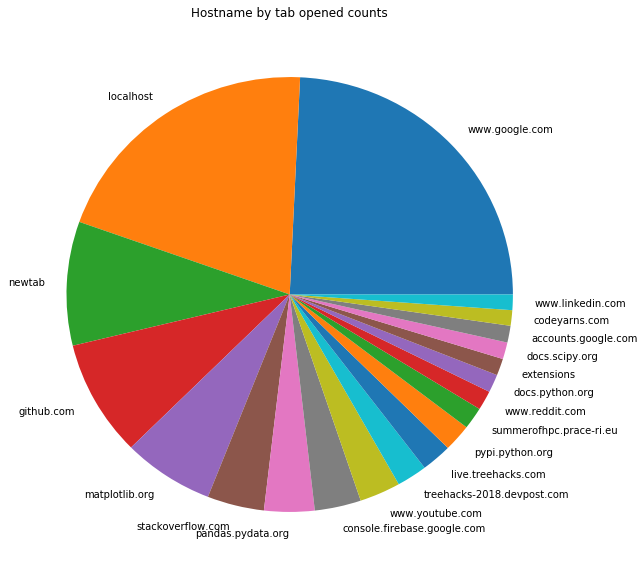

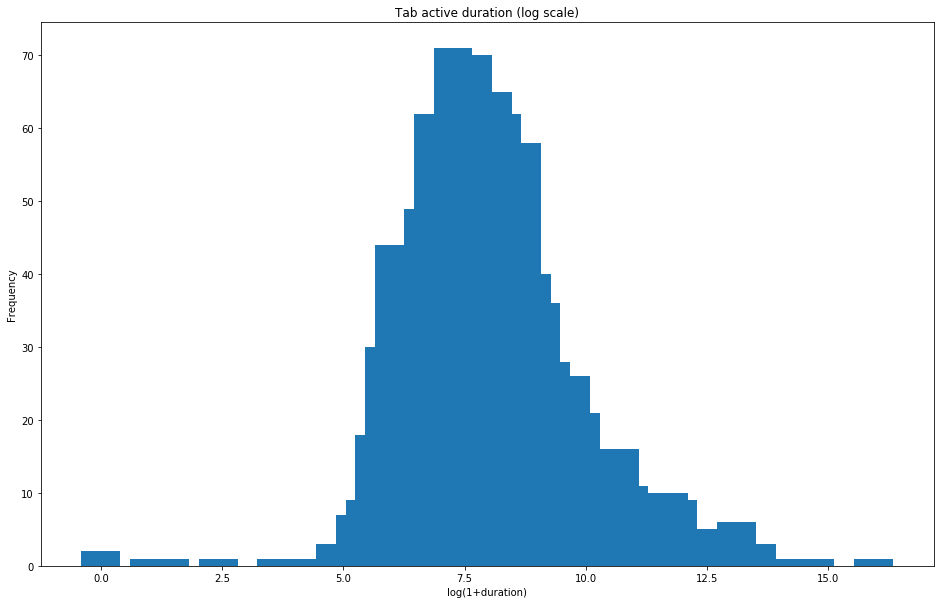

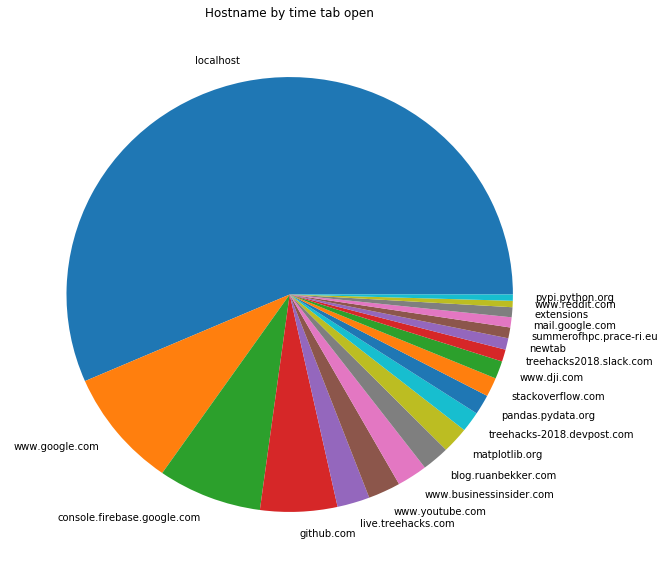

hostname_counts variance:  5.75232807605
hostname_times variance:  20.2964303149


In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(hostname_counts.values[:20], labels=hostname_counts.keys()[:20])
plt.title('Hostname by tab opened counts')

# the log of time spent on a tab is distributed like so
times = df['time'].as_matrix()
hist, bins = np.histogram(np.log(times+1), bins=80)
fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(bins[:-1], hist)
plt.title('Tab active duration (log scale)')
plt.ylabel('Frequency')
plt.xlabel('log(1+duration)')

# observe the difference between `newtab` in this vs the previous
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(hostname_times.values[:20], labels=hostname_times.keys()[:20])
plt.title('Hostname by time tab open')

plt.show()

print('hostname_counts variance: ', (hostname_counts.values / hostname_counts.values.mean()).var())
print('hostname_times variance: ', (hostname_times.values / hostname_times.values.mean()).var())

In [6]:
TIME_MULT = 3600000

rows = []
start_time = df.iloc[0]['startTime']
time = df.iloc[0]['endTime']
for i in range(len(df)):
    entry = df.iloc[i]
#     if entry['startTime'] < time:
#         continue
    rows.append([(entry['startTime']-start_time)/TIME_MULT, entry['time']/TIME_MULT, entry['hostname']])
    time = entry['endTime']

WORK_HOSTS = [
    'github.com',
    'matplotlib.org',
    'pandas.pydata.org',
    'stackoverflow.com',
    'console.firebase.google.com',
    'bokeh.pydata.org',
    'pymotw.com',
    'localhost',
    'www.google.com'
]
MEDIA_HOSTS = [
    'www.youtube.com',
    'www.reddit.com',
    'www.facebook.com',
    'www.businessinsider.com',
    'mail.google.com'
]

x_work, x_media, x_other = [], [], []
width_work, width_media, width_other = [], [], []
for row in rows:
    if row[2] in WORK_HOSTS:
        x_work.append(row[0])
        width_work.append(row[1])
    elif row[2] in MEDIA_HOSTS:
        x_media.append(row[0])
        width_media.append(row[1])
    else:
        x_other.append(row[0])
        width_other.append(row[1])

### Activity time series by URL category

Work, Media, Other

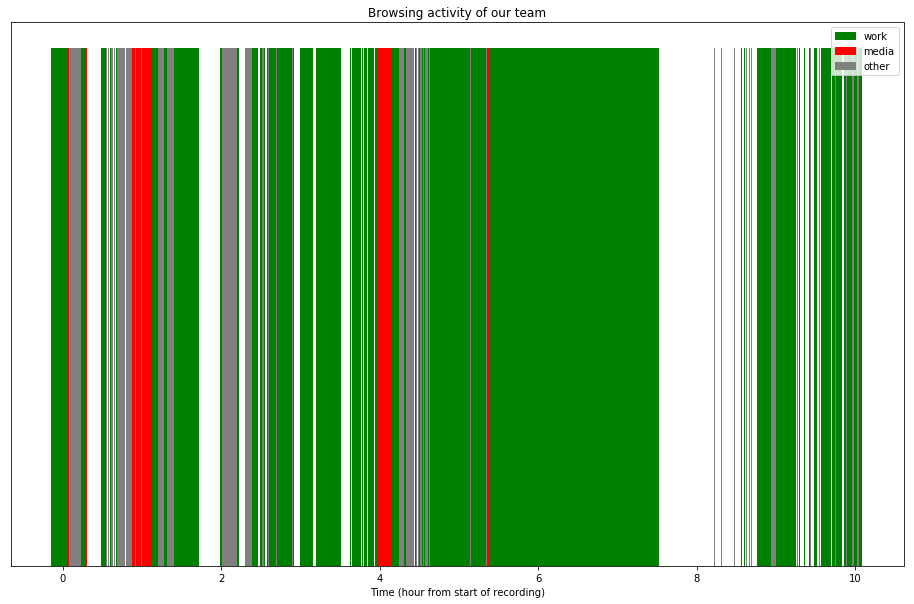

Total time spent on work: 9.67491777778 hours
Total time spent on media: 0.6842375 hours
Total time spent on other: 1.73870361111 hours


In [7]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(x_work, [1]*len(x_work), width_work, color='green')
ax.bar(x_media, [1]*len(x_media), width_media, color='red')
ax.bar(x_other, [1]*len(x_other), width_other, color='gray')
plt.title('Browsing activity of our team')
plt.xlabel('Time (hour from start of recording)')
plt.gca().axes.get_yaxis().set_ticks([])
patches = [mpatches.Patch(color='green', label='work'),
           mpatches.Patch(color='red', label='media'),
           mpatches.Patch(color='gray', label='other')]
plt.legend(handles=patches, loc='upper right')
plt.show()
print('Total time spent on %s:' % 'work', sum(width_work), 'hours')
print('Total time spent on %s:' % 'media', sum(width_media), 'hours')
print('Total time spent on %s:' % 'other', sum(width_other), 'hours')

### Sample Inference

With more data (on the order of a few weeks), interesting results become attainable. For example:

You have labeled `www.facebook.com` and `www.youtube.com` as `distracting`. We found that after visiting site `hackernews.ycombinator.com`, you then had an `86%` chance of visiting a `distracting` site in the next 20 tabs visited. Would you like to label `hackernews.ycombinator.com` as `distracting`?

### Inference of class for new URLs

By using co-occurrence with respect to previously classified hostnames, we can infer the class of previously unseen URLs.

In [8]:
top_count = 25
top_hostnames = df['hostname'].value_counts()[:top_count-1]
top_hostnames['<OTHER>'] = len(df) - top_hostnames.values.sum()

# coocurrence[i][j] := expected number of  js in the next w tabs after an i

coocurrence = np.zeros((top_count, top_count))

def get_index(hostname):
    if hostname in top_hostnames.keys()[:-1]:
        return top_hostnames.keys().get_loc(hostname)
    else:
        return len(top_hostnames.keys()) - 1

w = 20 # window size
for src in range(len(df)):
    i = get_index(df.iloc[src]['hostname'])
    for dst in range(src, min(src+w, len(df)-w)):
        j = get_index(df.iloc[dst]['hostname'])
        coocurrence[i, j] += 1

for i in range(top_count):
    coocurrence[i] /= top_hostnames[i]

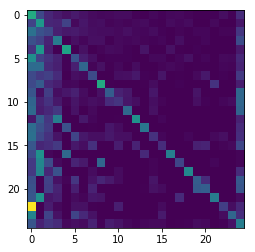

Top visited sites with most co-occurrent site:
www.reddit.com i.imgur.com
www.google.com stackoverflow.com
imgur.com www.netflix.com
github.com devpost.com
www.netflix.com imgur.com
mail.google.com cruzhacks-2018.slack.com
www.pythonanywhere.com server166.web-hosting.com:2083
devpost.com cruzhacks-2018.slack.com
www.hackthissite.org www.netflix.com
canvas.ucsc.edu login.ucsc.edu
i.imgur.com www.reddit.com
www.linkedin.com www.latimes.com
piazza.com canvas.ucsc.edu
login.ucsc.edu canvas.ucsc.edu
server166.web-hosting.com:2083 www.pythonanywhere.com
www.latimes.com www.linkedin.com
news.ycombinator.com www.netflix.com
stackoverflow.com www.google.com
cruzhacks-2018.slack.com devpost.com
www.nytimes.com www.linkedin.com
<UNK> www.reddit.com


In [9]:
coocurrence_norm = coocurrence / coocurrence.mean(axis=1)
plt.imshow(coocurrence)
plt.show()

from results import COOC_STRING

print("Top visited sites with most co-occurrent site:")
print(COOC_STRING)